In [124]:
import numpy as np
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from random import choice, shuffle
from numpy import array

In [125]:
def KMeansCluster(vectors, noofclusters):
    noofclusters = int(noofclusters)
    assert noofclusters < len(vectors)
    
    dim = len(vectors[0])
    vector_indices = list(range(len(vectors)))
    shuffle(vector_indices)
    graph = tf.Graph()
    with graph.as_default():
        sess = tf.Session()        
        centroids = [tf.Variable((vectors[vector_indices[i]]))
                     for i in range(noofclusters)]        
        centroid_value = tf.placeholder("float64", [dim])
        cent_assigns = []
        for centroid in centroids:
            cent_assigns.append(tf.assign(centroid, centroid_value))
        
        assignments = [tf.Variable(0) for i in range(len(vectors))]
        
        assignment_value = tf.placeholder("int32")
        cluster_assigns = []
        for assignment in assignments:
            cluster_assigns.append(tf.assign(assignment,
                                             assignment_value))
        mean_input = tf.placeholder("float", [None, dim])       
        mean_op = tf.reduce_mean(mean_input, 0)        
        v1 = tf.placeholder("float", [dim])
        v2 = tf.placeholder("float", [dim])
        euclid_dist = tf.sqrt(tf.reduce_sum(tf.pow(tf.subtract(
            v1, v2), 2)))
        centroid_distances = tf.placeholder("float", [noofclusters])
        cluster_assignment = tf.argmin(centroid_distances, 0)
        init_op = tf.global_variables_initializer()        
        sess.run(init_op)
        noofiterations = 20
        for iteration_n in range(noofiterations):
            for vector_n in range(len(vectors)):
                vect = vectors[vector_n]                
                distances = [sess.run(euclid_dist, feed_dict={
                    v1: vect, v2: sess.run(centroid)})
                             for centroid in centroids]                
                assignment = sess.run(cluster_assignment, feed_dict = {
                    centroid_distances: distances})                
                sess.run(cluster_assigns[vector_n], feed_dict={
                    assignment_value: assignment})            
            for cluster_n in range(noofclusters):
                assigned_vects = [vectors[i] for i in range(len(vectors))
                                  if sess.run(assignments[i]) == cluster_n]
                new_location = sess.run(mean_op, feed_dict={
                    mean_input: array(assigned_vects)})
                sess.run(cent_assigns[cluster_n], feed_dict={
                    centroid_value: new_location})
        centroids = sess.run(centroids)
        assignments = sess.run(assignments)
        return centroids, assignments

In [126]:
reviews_csv = "google_review_ratings.csv"
csv_file = pd.read_csv(reviews_csv)
src_data = csv_file

src_data.rename(columns={"Category 1":"churches", "Category 2":"resorts"}, inplace=True)
src_data.rename(columns={"Category 3":"beaches", "Category 4":"parks"}, inplace=True)
src_data.rename(columns={"Category 5":"theatres", "Category 6":"museums"}, inplace=True)
src_data.rename(columns={"Category 7":"malls", "Category 8":"zoo"}, inplace=True)
src_data.rename(columns={"Category 9":"restaurants", "Category 10":"pubs/bars"}, inplace=True)
src_data.rename(columns={"Category 11":"local services", "Category 12":"burger/pizza shops"}, inplace=True)
src_data.rename(columns={"Category 13":"hotels/other lodgings", "Category 14":"juice bars"}, inplace=True)
src_data.rename(columns={"Category 15":"art galleries", "Category 16":"dance clubs"}, inplace=True)
src_data.rename(columns={"Category 17":"swimming pools", "Category 18":"gyms"}, inplace=True)
src_data.rename(columns={"Category 19":"bakeries", "Category 20":"beauty & spas"}, inplace=True)
src_data.rename(columns={"Category 21":"cafes", "Category 22":"view points"}, inplace=True)
src_data.rename(columns={"Category 23":"monuments", "Category 24":"gardens"}, inplace=True)
src_data.drop(["Unnamed: 25"], axis=1, inplace=True)
src_data.drop(["User"], axis=1, inplace=True)

src_data.head(5)

,churches,resorts,beaches,parks,theatres,museums,malls,zoo,restaurants,pubs/bars,...,art galleries,dance clubs,swimming pools,gyms,bakeries,beauty & spas,cafes,view points,monuments,gardens
0,0.0,0.0,3.63,3.65,5.0,2.92,5.0,2.35,2.33,2.64,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,3.63,3.65,5.0,2.92,5.0,2.64,2.33,2.65,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,3.63,3.63,5.0,2.92,5.0,2.64,2.33,2.64,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
3,0.0,0.5,3.63,3.63,5.0,2.92,5.0,2.35,2.33,2.64,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,3.63,3.63,5.0,2.92,5.0,2.64,2.33,2.64,...,1.74,0.59,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0


In [127]:
#低方差
var = src_data.var()
for i in range(0, len(var)):
    if var[i] < 1:
        src_data.drop(src_data.columns[i], axis=1, inplace=True)

#高相關
corr = src_data.corr()
columns = corr.columns
for i in corr.columns:    
    for j in columns:
        if corr.loc[i][j]<1 and corr.loc[i][j]>0.7:
            src_data.drop(src_data.columns[j], axis=1, inplace=True)
            print("keep"+i+", drop"+j+"\n")            
    columns = columns.drop(i)
            

In [128]:
csv_file["local services"] = pd.to_numeric(csv_file["local services"], errors='coerce')
srcdata = csv_file.to_numpy() 

In [135]:
#Clustering
k=3
srcdata = srcdata[0:1000,:]
center, result = KMeansCluster(srcdata, k)
print(center)

[array([1.98164248, 2.14869499, 2.11600733, 2.67955256, 2.82317305,
       3.69235039, 3.36477757, 3.87164259, 3.54365873, 3.52104568,
       2.24388146, 2.88656878, 2.64313483, 1.22746241, 1.364851  ,
       0.7941044 , 0.59070879, 0.61861932, 1.49914253, 1.44153094]), array([2.53749371, 3.16207075, 3.54206634, 3.51755905, 3.19471478,
       2.7889924 , 2.19849515, 2.47956109, 2.45937109, 2.19534516,
       1.59594917, 1.34459257, 1.25651431, 1.53434289, 1.30392408,
       0.78615844, 1.11691022, 1.17757857, 2.58196235, 1.7695421 ]), array([2.07008028, 2.10826182, 2.11292458, 2.37498093, 2.76351857,
       3.94308281, 2.82900977, 4.09743023, 3.57236981, 2.44952536,
       2.43474412, 3.03470349, 3.72719407, 4.96766806, 1.06802344,
       0.83873528, 1.02221358, 0.84320158, 0.9221341 , 0.97106731])]


In [136]:
res = pd.DataFrame(srcdata)
res["kmeans_res"] = 0
for i in range(len(res)):    
    res["kmeans_res"].values[i] = result[i]
    
#res["kmeans_res"] = res["kmeans_res"].astype(str)
res

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,kmeans_res
0,0.00,3.63,3.65,5.00,2.92,5.00,2.35,2.33,2.64,1.70,...,1.70,1.72,1.74,0.59,0.00,0.00,0.00,0.00,0.00,1
1,0.00,3.63,3.65,5.00,2.92,5.00,2.64,2.33,2.65,1.70,...,1.70,1.72,1.74,0.59,0.00,0.00,0.00,0.00,0.00,1
2,0.00,3.63,3.63,5.00,2.92,5.00,2.64,2.33,2.64,1.70,...,1.70,1.72,1.74,0.59,0.00,0.00,0.00,0.00,0.00,1
3,0.50,3.63,3.63,5.00,2.92,5.00,2.35,2.33,2.64,1.73,...,1.70,1.72,1.74,0.59,0.00,0.00,0.00,0.00,0.00,1
4,0.00,3.63,3.63,5.00,2.92,5.00,2.64,2.33,2.64,1.70,...,1.70,1.72,1.74,0.59,0.00,0.00,0.00,0.00,0.00,1
5,0.00,3.63,3.63,5.00,2.92,5.00,2.63,2.33,2.65,1.71,...,1.69,1.72,1.74,0.59,0.00,0.00,0.00,0.00,0.00,1
6,5.00,3.63,3.63,5.00,2.92,3.03,2.35,2.33,2.64,1.73,...,1.69,1.71,1.75,0.59,0.00,0.00,0.00,0.00,0.00,1
7,5.00,3.63,3.63,5.00,2.92,5.00,2.63,2.33,2.64,1.70,...,1.69,1.71,1.74,0.60,0.00,0.00,0.00,0.00,0.00,1
8,5.00,3.64,3.64,5.00,2.92,3.03,2.62,2.32,2.63,1.71,...,1.68,1.70,0.75,0.60,0.00,0.00,0.00,0.00,0.00,1
9,5.00,3.64,3.64,5.00,2.92,5.00,2.35,2.32,2.63,1.69,...,1.67,1.70,0.74,0.59,0.00,0.00,0.00,0.00,0.00,1


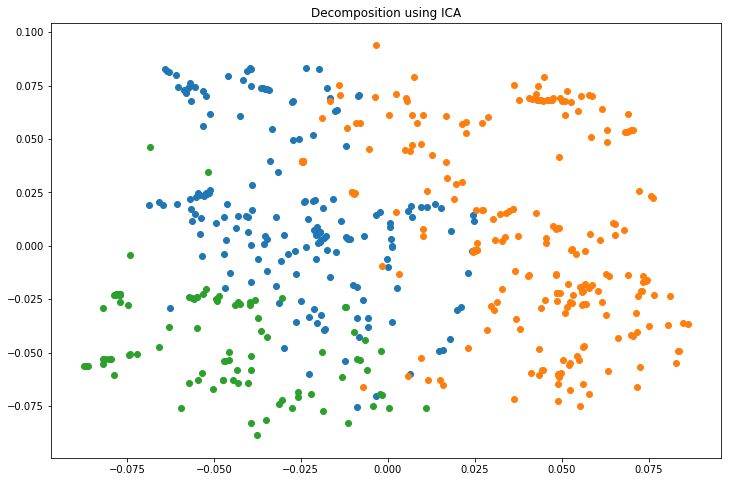

In [137]:
#Projection Base
from sklearn.decomposition import FastICA 
ICA = FastICA(n_components=2, random_state=12) 
X = ICA.fit_transform(tmp_data.values)
X = pd.DataFrame(X)

X["kmeans_res"] = 0
for i in range(len(X)):    
    X["kmeans_res"].values[i] = result[i]

plt.figure(figsize=(12,8))
plt.title('Decomposition using ICA')

for i in range(k):
    plt.scatter(X[X['kmeans_res']==i].values[:,0], X[X['kmeans_res']==i].values[:,1])


C:\Users\Tartarus\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


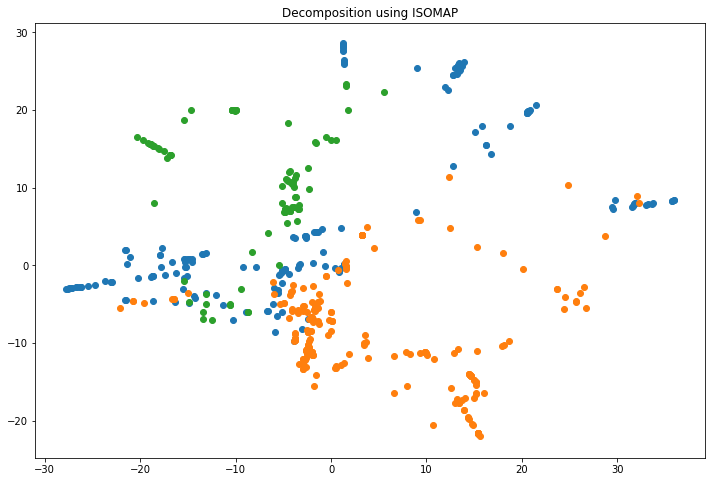

In [138]:
#Factors Base
from sklearn import manifold 
trans_data = manifold.Isomap(n_neighbors=5, n_components=2, n_jobs=-1).fit_transform(tmp_data.values)

trans_data = pd.DataFrame(trans_data)

trans_data["kmeans_res"] = 0
for i in range(len(trans_data)):    
    trans_data["kmeans_res"].values[i] = result[i]

plt.figure(figsize=(12,8))
plt.title('Decomposition using ISOMAP')
for i in range(k):
    plt.scatter(trans_data[trans_data['kmeans_res']==i].values[:,0], trans_data[trans_data['kmeans_res']==i].values[:,1])